<a href="https://colab.research.google.com/github/Jalapinho1/Deep-Reinforcement-Learning-Explained/blob/main/RFL_PolicyBasedMethods.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Hill Climbing**

In [3]:
import gym
import numpy as np
from collections import deque
import matplotlib.pyplot as plt

In [2]:
# Taken from 
# https://towardsdatascience.com/rendering-openai-gym-envs-on-binder-and-google-colab-536f99391cc7

!apt-get install -y xvfb x11-utils

!pip install pyvirtualdisplay==0.2.* \
             PyOpenGL==3.1.* \
             PyOpenGL-accelerate==3.1.*

!pip install gym[box2d]==0.17.*

# Taken from https://github.com/actions/virtual-environments/issues/214
!sudo apt-get update
!sudo apt-get install xvfb --fix-missing

import pyvirtualdisplay

_display = pyvirtualdisplay.Display(visible=False, size=(1400, 900))
_ = _display.start()

!echo $DISPLAY # sanity checking should now be set to some value

from IPython import display

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libxxf86dga1
Suggested packages:
  mesa-utils
The following NEW packages will be installed:
  libxxf86dga1 x11-utils xvfb
0 upgraded, 3 newly installed, 0 to remove and 15 not upgraded.
Need to get 993 kB of archives.
After this operation, 2,981 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 libxxf86dga1 amd64 2:1.1.4-1 [13.7 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/main amd64 x11-utils amd64 7.7+3build1 [196 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 xvfb amd64 2:1.19.6-1ubuntu4.8 [784 kB]
Fetched 993 kB in 0s (9,719 kB/s)
Selecting previously unselected package libxxf86dga1:amd64.
(Reading database ... 145480 files and directories currently installed.)
Preparing to unpack .../libxxf86dga1_2%3a1.1.4-1_amd64.deb ...
Unpacking libxxf86dga1:amd64 (2:

In [3]:
env = gym.make('CartPole-v0')
print('observation space:', env.observation_space)
print('action space:', env.action_space)
print('threshold: ', env.spec.reward_threshold)

observation space: Box(-3.4028234663852886e+38, 3.4028234663852886e+38, (4,), float32)
action space: Discrete(2)
threshold:  195.0


The policy π (and its initialization with random weights θ) can be coded as:


In [4]:
class Policy():
    def __init__(self, s_size=4, a_size=2):
        # 1. Initialize policy π with random weights θ
        # weights for simple linear policy: state_space x action_space
        self.θ = 1e-4*np.random.rand(s_size, a_size)  
        
    def forward(self, state):
        x = np.dot(state, self.θ)
        return np.exp(x)/sum(np.exp(x))
    
    def act(self, state):
        probs = self.forward(state)
        action = np.argmax(probs)             
        return action

To visualize the training’s effect, we plot the weights θ before and after the training and render how the Agent apply the policy:

In [5]:
def watch_agent():
  env = gym.make('CartPole-v0')
  state = env.reset()
  rewards = []
  img = plt.imshow(env.render(mode='rgb_array'))
  for t in range(2000):
    action = policy.act(state)
    img.set_data(env.render(mode='rgb_array')) 
    plt.axis('off')
    display.display(plt.gcf())
    display.clear_output(wait=True)
    state, reward, done, _ = env.step(action)
    rewards.append(reward)
    if done:
        print("Reward:", sum([r for r in rewards]))
        break 
  env.close()

In [13]:
policy = Policy()
print ("Policy weights θ before train:\n", policy.θ)

Policy weights θ before train:
 [[5.96506314e-05 9.87084947e-05]
 [9.49812979e-05 6.25996539e-05]
 [1.79652127e-05 1.01385527e-05]
 [4.27035894e-05 1.93391052e-05]]


In [ ]:
watch_agent()

The following code defines the function that trains the Agent:


In [18]:
def hill_climbing(n_episodes=10000, gamma=1.0, noise=1e-2):
    """Implementation of hill climbing.     
    Params
    ======
        n_episodes (int): maximum number of training episodes
        gamma (float): discount rate
        noise(float): standard deviation of additive noise
    """
    scores_deque = deque(maxlen=100)
    scores = []
    
    #2. Initialize θbest (our best guess for the weights θ)
    #3. Initialize Gbest (our highest return G we have gotten so far)
    Gbest = -np.Inf
    θbest = policy.θ
    for i_episode in range(1, n_episodes+1):
        rewards = []
        state = env.reset()
        while True:
        #4. Collect a single episode with θ, and record the return G
            action = policy.act(state)
            state, reward, done, _ = env.step(action)
            rewards.append(reward)
            if done:
                break 
        scores_deque.append(sum(rewards))
        scores.append(sum(rewards))

        discounts = [gamma**i for i in range(len(rewards)+1)]
        G = sum([a*b for a,b in zip(discounts, rewards)])

        if G >= Gbest: # 5. If G>Gbest then θbest←θ & Gbest←G
            Gbest = G
            θbest = policy.θ
        
        #6. Add a little bit of random noise to θbest, to get a new set of weights θ
        policy.θ = θbest + noise * np.random.rand(*policy.θ.shape)

        if i_episode % 10 == 0:
            print('Episode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))

        # 7. Repeat steps 4-6 until Environment solved.    
        if np.mean(scores_deque)>=env.spec.reward_threshold:
            print('Environment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
            policy.θ = θbest
            break
        
    return scores

In [19]:
scores = hill_climbing(gamma=0.9)


Episode 10	Average Score: 106.10
Episode 20	Average Score: 124.90
Episode 30	Average Score: 116.80
Episode 40	Average Score: 117.70
Episode 50	Average Score: 113.54
Episode 60	Average Score: 117.43
Episode 70	Average Score: 122.30
Episode 80	Average Score: 125.29
Episode 90	Average Score: 129.17
Episode 100	Average Score: 130.93
Episode 110	Average Score: 137.95
Episode 120	Average Score: 143.58
Episode 130	Average Score: 153.52
Episode 140	Average Score: 159.56
Episode 150	Average Score: 169.46
Episode 160	Average Score: 175.56
Episode 170	Average Score: 179.54
Episode 180	Average Score: 184.92
Episode 190	Average Score: 188.90
Episode 200	Average Score: 192.66
Episode 210	Average Score: 194.00
Episode 220	Average Score: 193.21
Episode 230	Average Score: 191.57
Episode 240	Average Score: 193.31
Episode 250	Average Score: 193.72
Episode 260	Average Score: 193.47
Episode 270	Average Score: 194.34
Episode 280	Average Score: 194.34
Episode 290	Average Score: 194.34
Environment solved in 2

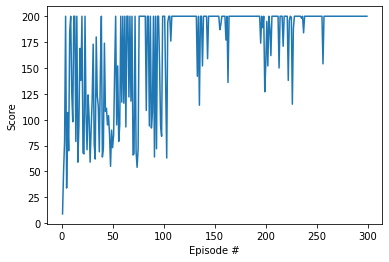

In [20]:
fig = plt.figure()
#ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [21]:
print ("Policy weights θ after train:\n", policy.θ)


Policy weights θ after train:
 [[0.99461847 0.97990184]
 [1.03413132 1.07247061]
 [1.02918432 1.04674339]
 [1.04618747 1.11940143]]


In [1]:
watch_agent()

NameError: ignored